In [1]:
!pip install faiss-cpu --no-cache

     ---------------------------------------- 10.4/10.4 MB 4.4 MB/s eta 0:00:00


In [2]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['DASK_TEMP_DIR'] = 'Z:/temp_data'
warnings.filterwarnings('ignore')

import tqdm
import pickle 
import random
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import pyarrow as pa
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder

In [2]:
def reduce_mem_usage(df):
    
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:    
        
        
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns]']:
                
                
                
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                    
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df #= reduce_mem_usage(df)

In [3]:
public_train = pd.read_parquet('E:/mts/public_train.pqt')
id_to_submit = pd.read_parquet('E:/mts/submit_2.pqt')

In [4]:
# df = pd.read_feather('E:/mts/mapped_inted_df.feather')
# df = df.merge(public_train, how='outer', on='user_id')
# train = df[~df['age'].isna()]
# train = train.reset_index()
# train.to_feather('E:/mts/train_age.feather')

# test = df[df['age'].isna()]
# test = test.reset_index()
# test.to_feather('E:/mts/test_age.feather')


In [8]:
train = pd.read_feather('E:/mts/train_age.feather')
train = train.drop(['index'], axis=1)
train = reduce_mem_usage(train)

Memory usage of dataframe is 9244.52 MB
Memory usage after optimization is: 9244.52 MB
Decreased by 0.0%


# region_name

In [9]:
train.region_name.value_counts()

22    29874927
17    17421057
28    13439269
69    13173150
30    10599680
        ...   
56       57669
50       55790
79       13284
62        6293
12           6
Name: region_name, Length: 81, dtype: int64

<AxesSubplot: >

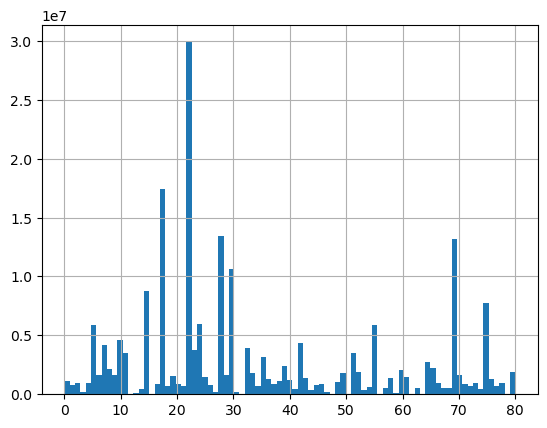

In [10]:
train.region_name.hist(bins=85)

# city_name

In [11]:
train.city_name.value_counts()

600    29874927
729    13173150
888     6013173
343     5912065
556     5239213
         ...   
325          13
163          11
504           7
628           6
534           1
Name: city_name, Length: 985, dtype: int64

<AxesSubplot: >

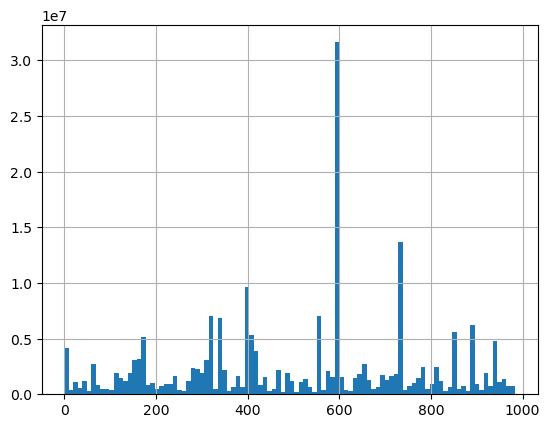

In [19]:
train.city_name.hist(bins=100)

# cpe_manufacturer_name

In [13]:
train.cpe_manufacturer_name.value_counts()

19    81492716
5     52601647
17    40221008
20    30760990
30     1172574
4      1069541
33      828104
35      813635
25      345056
14      288841
29      220843
32      183406
0       163634
34      135026
28      111869
16       52341
9        50973
1        45205
36       33409
23       28379
31       21370
27       20726
26       12382
6         8477
3         7514
18        5568
22        5326
11        5083
13        4937
10        4775
21        3560
2         3390
15        3353
7         1410
12        1287
8         1094
24         560
Name: cpe_manufacturer_name, dtype: int64

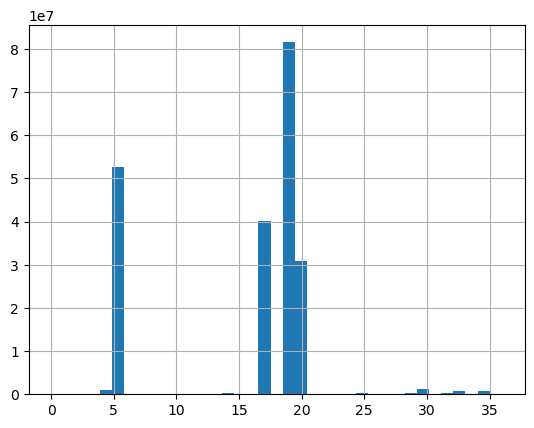

In [14]:
train.cpe_manufacturer_name.hist(bins=37);

# cpe_model_name

In [20]:
train.cpe_model_name.value_counts()

416    19160505
432    10287977
294     7774306
246     6777404
559     5839472
         ...   
349         110
119          25
309          23
227          22
545          19
Name: cpe_model_name, Length: 599, dtype: int64

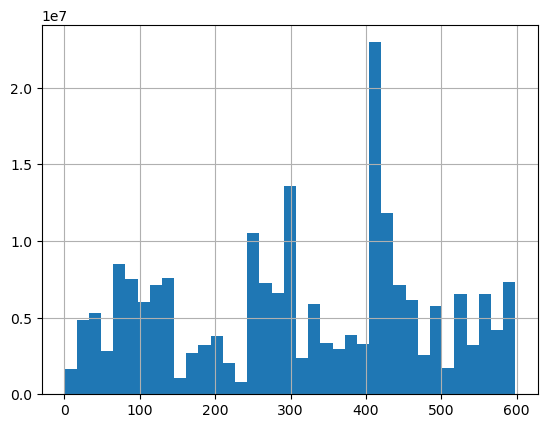

In [21]:
train.cpe_model_name.hist(bins=37);

# url_host

In [17]:
train.url_host.value_counts()

178373    14369088
196012    12413011
69529     11044928
57361     10898540
129494    10586504
            ...   
11729            1
76451            1
169426           1
158154           1
20989            1
Name: url_host, Length: 172054, dtype: int64

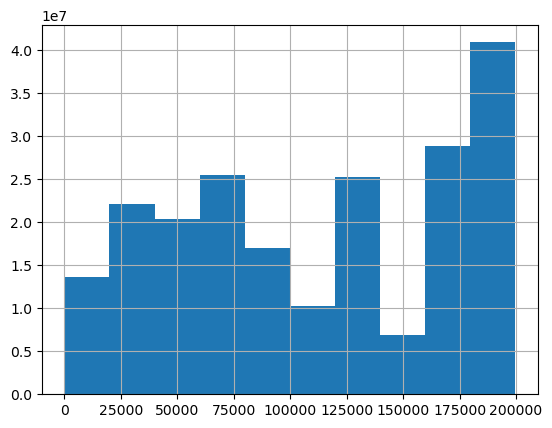

In [18]:
train.url_host.hist();

# cpe_type_cd

In [22]:
train.cpe_type_cd.value_counts()

1    210656245
2        36044
0        20531
3        17189
Name: cpe_type_cd, dtype: int64

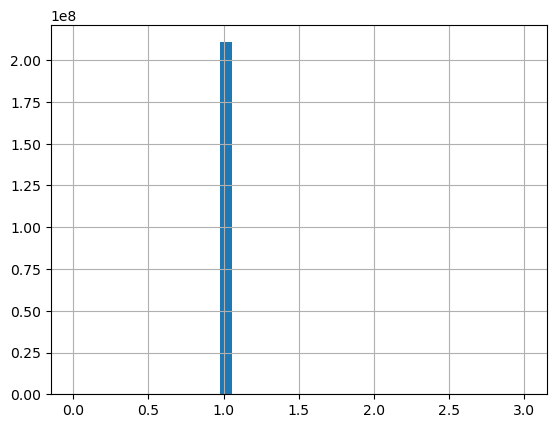

In [23]:
train.cpe_type_cd.hist(bins=37);

In [24]:
train

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,part_of_day,price,date,request_cnt,user_id,age,is_male
0,69,729,5,88,21359,1,0,0,75000.0,2021-09-26,1,79395,35.0,1
1,69,729,5,88,69529,1,0,1,75000.0,2021-08-21,3,79395,35.0,1
2,69,729,5,88,164131,1,0,1,75000.0,2021-08-20,3,79395,35.0,1
3,29,917,5,88,164131,1,0,3,75000.0,2021-09-09,2,79395,35.0,1
4,69,729,5,88,37191,1,0,1,75000.0,2021-08-30,1,79395,35.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210730004,48,402,5,467,129494,1,0,2,20000.0,2021-07-12,1,300964,57.0,0
210730005,48,402,5,467,178373,1,0,3,20000.0,2021-06-20,1,300964,57.0,0
210730006,48,402,5,467,14814,1,0,1,20000.0,2021-08-05,1,300964,57.0,0
210730007,48,402,5,467,48867,1,0,3,20000.0,2021-07-19,1,300964,57.0,0


# cpe_model_os_type

In [25]:
train.cpe_model_os_type.value_counts()

0    129237293
2     80061244
1      1431472
Name: cpe_model_os_type, dtype: int64

<AxesSubplot: >

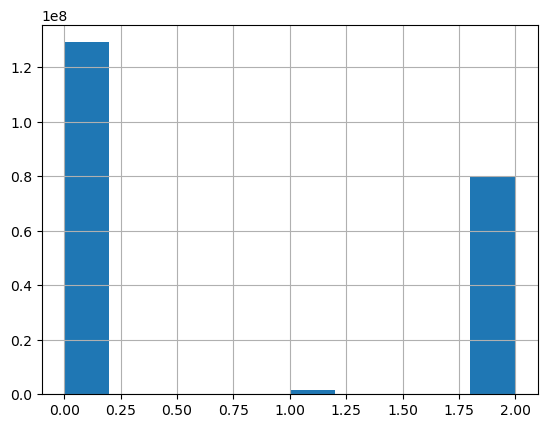

In [26]:
train.cpe_model_os_type.hist()

# part_of_day

In [27]:
train.part_of_day.value_counts()

1    70023248
3    62827774
2    55570501
0    22308486
Name: part_of_day, dtype: int64

<AxesSubplot: >

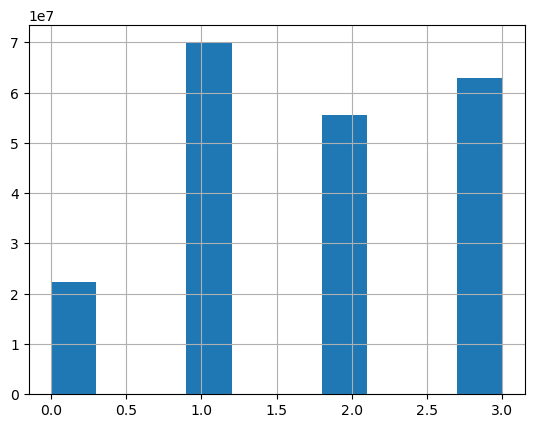

In [28]:
train.part_of_day.hist()

# price

In [30]:
def round_by_5000(num):
    base = 5000
    temp = num // base * base
    return temp + base

In [31]:
train['price'] = train['price'].map(round_by_5000)

In [32]:
train.price.value_counts()

20000.0     34026338
25000.0     30926657
15000.0     22066443
30000.0     19856861
65000.0     13861438
35000.0     12321337
55000.0     11524028
70000.0      8667433
60000.0      7695371
40000.0      7177116
50000.0      6034788
10000.0      5636143
45000.0      5444880
75000.0      3459922
90000.0      2905916
105000.0     2120897
80000.0      1911296
100000.0     1764689
110000.0     1758388
95000.0      1714333
120000.0     1630811
85000.0      1497490
125000.0     1393787
115000.0      947737
130000.0       56679
135000.0       12654
145000.0       10358
140000.0        9783
150000.0        5731
170000.0        5293
190000.0        4764
165000.0        4372
200000.0        3137
205000.0        3115
160000.0        2267
180000.0        1487
185000.0         230
155000.0         168
175000.0          68
Name: price, dtype: int64

<AxesSubplot: >

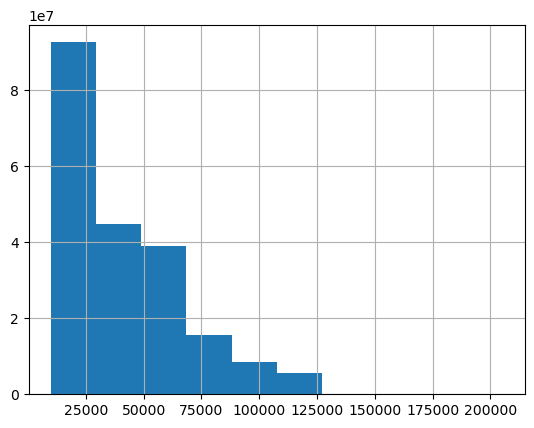

In [33]:
train.price.hist()

# date

(array([18809., 18871., 18932., 18993., 19052., 19113., 19174., 19236.,
        19297.]),
 [Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11')])

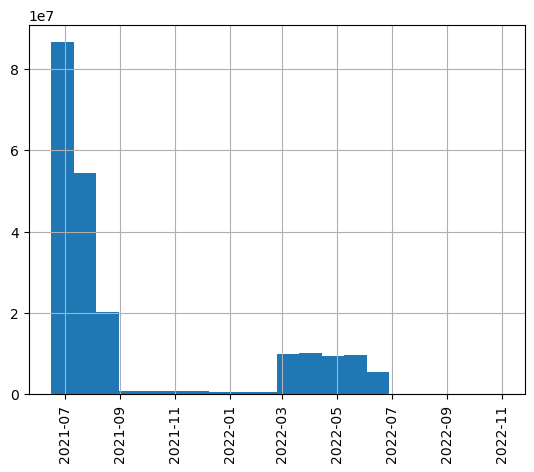

In [41]:
train['date'].hist(bins=20)
plt.xticks(rotation=90)

In [42]:
train

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,part_of_day,price,date,request_cnt,user_id,age,is_male
0,69,729,5,88,21359,1,0,0,80000.0,2021-09-26,1,79395,35.0,1
1,69,729,5,88,69529,1,0,1,80000.0,2021-08-21,3,79395,35.0,1
2,69,729,5,88,164131,1,0,1,80000.0,2021-08-20,3,79395,35.0,1
3,29,917,5,88,164131,1,0,3,80000.0,2021-09-09,2,79395,35.0,1
4,69,729,5,88,37191,1,0,1,80000.0,2021-08-30,1,79395,35.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210730004,48,402,5,467,129494,1,0,2,25000.0,2021-07-12,1,300964,57.0,0
210730005,48,402,5,467,178373,1,0,3,25000.0,2021-06-20,1,300964,57.0,0
210730006,48,402,5,467,14814,1,0,1,25000.0,2021-08-05,1,300964,57.0,0
210730007,48,402,5,467,48867,1,0,3,25000.0,2021-07-19,1,300964,57.0,0


In [43]:
train['week'] = train['date'].apply(lambda x: x.week)

MemoryError: Unable to allocate 1.57 GiB for an array with shape (210730009,) and data type int64